## Библиотеки

In [ ]:
# Чтобы ноутбук работал правильно необходимо проверить, что скачаны следующие библиотеки:
# !pip install seaborn
# !pip install numpy
# !pip install matplotlib
# !pip install pandas
# !pip install implicit
# !pip install scikit-learn

In [2]:
from abc import ABC, abstractmethod
from typing import Dict, List
import warnings

# Работа с таблицам
import numpy as np
import pandas as pd

# Пакеты для сollaborative filtering (я работал с пакетом implicit)
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import CosineRecommender, BM25Recommender, TFIDFRecommender
from implicit.bpr import BayesianPersonalizedRanking
from implicit.lmf import LogisticMatrixFactorization

# Вспомогательные пакеты
from scipy.sparse import csr_matrix, coo_matrix
from sklearn.preprocessing import LabelEncoder

# Методы для content-based filtering
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer

# Визуализация/из
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

Для построения моделей матричной факторизации, я работал с пакетом **Implicit**.

Данная бибилиотека была выбрана, так как она расчитана для построения рекомендательных систем на основе датасетов с **неявным таргетом**

`Репозиторий` - https://github.com/benfred/implicit

`Документация` - https://benfred.github.io/implicit/

`Входные данные` - разреженные матрицы (csr_matrix/coo_matrix) с типом float32/float64

## Данные

В качестве данных был использован датасет от MTS.AI: [kion-data](https://arxiv.org/pdf/2209.00325.pdf).  

In [3]:
data_folder = "kion_data/"

users_df = pd.read_csv(data_folder + "users.csv")
items_df = pd.read_csv(data_folder + "items.csv")
train_part = pd.read_csv(data_folder + "train_data.csv", parse_dates=["last_watch_dt"])
test_part = pd.read_csv(data_folder + "test_data.csv")
test_part = test_part.groupby("user_id").agg({"ground_truth": list}).reset_index()

Какие есть `user`-features?

1. `user_id` – индентификатор пользователя, уникален для каждого
2. `age` – категориальный признак, показывающий возрастную группу пользователя
3. `income` – категориальный признак, показывающий зарплатную группу пользователя
4. `sex` – пол пользователя
5. `kids_flg` – наличие детей у пользователя

Какие есть `item`-признаки?

1. `item_id` – индентификатор айтема, уникален для каждого
2. `content_type` – категориальный признак, тип айтема (фильм, сериал и т.д.)
3. `title` – Название на русском языке
4. `title_orig` – Название на языке оригинала
5. `release_year` – год выхода 
6. `genres` – список жанров (представлен строкой)
7. `countries` – страна издания
8. `for_kids` – предназначен для детей
9. `age_rating` – возрастной рейтинг картины
10. `studios` – студия, выпустившая картину
11. `directors` – режиссер(ы)
12. `actors` – актёры
13. `description` – описание (на русском)
14. `keywords` – ключевые слова, описывающие картину

## Метрики

Для измерения качества моделей используются две метрики: **ndcg** и **recall**.  

Задача отдать 10 самых подходящих пользователю айтемов, это и есть наши рекомендации, качество которых мы хотим оценить.  

**ndcg** показывает, как модель справляется с задачей ранжирования, то есть ставит просмотренные айтемы выше непросмотренных.

**recall** показывает, как много релевантных айтемов модель выдаёт в топе (смысл как в задаче классификации)

*Для обоих метрик лучше та, которая как можно ближе к **1.0***

Ниже представлен код реализации:

In [4]:
def ndcg_metric(gt_items: np.ndarray, predicted: np.ndarray) -> float:
    at = len(predicted)
    relevance = np.array([1 if x in predicted else 0 for x in gt_items])
    # DCG uses the relevance of the recommended items
    rank_dcg = dcg(relevance)
    if rank_dcg == 0.0:
        return 0.0

    # IDCG has all relevances to 1 (or the values provided), up to the number of items in the test set that can fit in the list length
    ideal_dcg = dcg(np.sort(relevance)[::-1][:at])

    if ideal_dcg == 0.0:
        return 0.0

    ndcg_ = rank_dcg / ideal_dcg

    return ndcg_


def dcg(scores: np.ndarray) -> float:
    return np.sum(
        np.divide(np.power(2, scores) - 1, np.log2(np.arange(scores.shape[0], dtype=np.float64) + 2)), dtype=np.float64
    )


def recall_metric(gt_items: np.ndarray, predicted: np.ndarray) -> float:
    n_gt = len(gt_items)
    intersection = len(set(gt_items).intersection(set(predicted)))
    return intersection / n_gt


def evaluate_recommender(df: pd.DataFrame, model_preds_col: str, gt_col: str = "ground_truth") -> Dict[str, float]:
    metric_values = []

    for _, row in df.iterrows():
        metric_values.append(
            (ndcg_metric(row[gt_col], row[model_preds_col]), recall_metric(row[gt_col], row[model_preds_col]))
        )

    return {"ndcg": np.mean([x[0] for x in metric_values]), "recall": np.mean([x[1] for x in metric_values])}

## EDA начальных данных

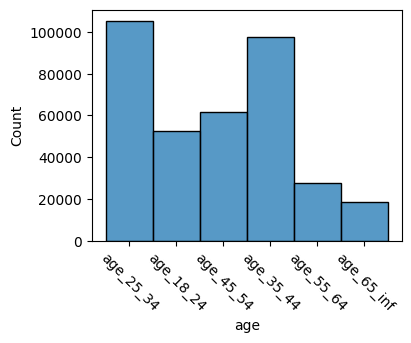

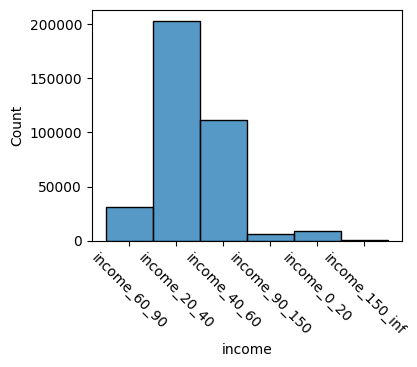

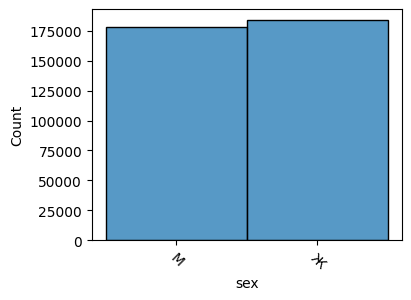

In [37]:
feature_names = ['age', 'income','sex']
users_np = np.array(users_df)

for i in range(1,4):
    # создадим пустой график (для каждого признака создаем свое полотно)
    plt.figure(figsize=(4,3))
    # построим гистограмму для выбранного признака
    sns.histplot(users_np[:,i]);
    plt.xticks(rotation=-45)
    # добавим подпись к оси x
    plt.xlabel(feature_names[i-1])
    # отобразим график
    plt.show()

In [59]:
items_df_2 = items_df.copy()
items_df_2['genres'] = items_df_2['genres'].fillna('Жанр неизвестен')
genres = items_df_2['genres'].str.split(',').explode().unique()
print(f"Первые 20 жанров: {genres[:20]} \n Всего жанров в выборке: {len(genres)}")

Первые 20 жанров: ['драмы' ' зарубежные' ' детективы' ' мелодрамы' 'зарубежные'
 ' приключения' ' комедии' 'криминал' ' триллеры' ' боевики' 'для детей'
 ' сказки' ' полнометражные' ' семейное' ' западные мультфильмы' ' драмы'
 'русские' 'биография' ' экранизации' 'боевики'] 
 Всего количество жанров в выборке: 153


In [61]:
items_df_2['countries'] = items_df_2['countries'].fillna('Страна неизвестна')
countries = items_df_2['countries'].str.split(',').explode().unique()
print(f"Первые 20 жанров: {countries[:20]} \n Всего стран в выборке: {len(countries)}")

Первые 20 жанров: ['Испания' 'США' 'Канада' 'Великобритания' 'Россия' 'СССР' 'Германия'
 'Италия' 'Аргентина' 'Франция' ' Германия' ' Япония' ' Великобритания'
 'Швеция' 'Норвегия' ' Канада' ' Италия' ' Швеция' 'Чехия' 'Китай'] 
 Всего стран в выборке: 152


## Content-Based filtering

**Content Based Filtering** 

Данный способ рекомендаций предлагает похожие предметы на основе конкретного элемента. Эта система использует метаданные элемента, такие как жанр, режиссер, описание, актеры и т.д. для фильмов. Общая идея за этими системами рекомендаций заключается в том, что если человеку понравился определенный элемент, ему также понравится элемент, похожий на него.
Я попробовал различные варианты сочетаний `description + keyword`, `keyword + actors`, `description + genres` и т.д. Так как результатов получилось очень много, ниже я демонстрирую код, выдавший *лучшие метрики*.

Мы вычислим попарные оценки сходства для всех фильмов на основе **описаний** их сюжета и будем рекомендовать фильмы на основе этой оценки сходства.Для этого необходимо преобразовать вектор слов для каждого фильма. Вычислим векторы Term Frequency-Inverse Document Frequency 
(TF-IDF) для каждого фильма.

**Term Frequency** - это относительная частота слова в документе и вычисляется как (количество вхождений термина / общее количество вхождений). 

**Inverse Document Frequency** - относительное количество Document, содержащих термин, и вычисляется как логарифм (количество Document / количество Document с термином).

В итоге получим матрицу, в которой каждый столбец представляет слово из словаря обзоров (все слова, которые появляются хотя бы в одном Document), и каждая строка представляет фильм, как и раньше

In [63]:
# Заменяем значения NaN пустой строкой
items_df['description'] = items_df['description'].fillna('')

In [28]:
# Созданием словаря русских стоп-слов
rus_stop_words = stop_words = [
    "и", "в", "во", "не", "что", "он", "на", "я", "с", "со", "как", "а", "то", "все",
    "она", "так", "его", "но", "да", "ты", "к", "у", "же", "вы", "за", "бы", "по",
    "только", "ее", "мне", "было", "вот", "от", "меня", "еще", "нет", "о", "из", "ему",
    "теперь", "когда", "даже", "ну", "вдруг", "ли", "если", "уже", "или", "ни", "быть",
    "был", "него", "до", "вас", "нибудь", "опять", "уж", "вам", "ведь", "там", "потом",
    "себя", "ничего", "ей", "может", "они", "тут", "где", "есть", "надо", "ней", "для",
    "мы", "тебя", "их", "чем", "была", "сам", "чтоб", "без", "будто", "чего", "раз",
    "тоже", "себе", "под", "будет", "ж", "тогда", "кто", "этот", "того", "потому", "этого",
    "какой", "совсем", "ним", "здесь", "этом", "один", "почти", "мой", "тем", "чтобы",
    "нее", "сейчас", "были", "куда", "зачем", "всех", "никогда", "можно", "при", "наконец",
    "два", "об", "другой", "хоть", "после", "над", "больше", "тот", "через", "эти", "нас"
    "про", "всего", "них", "какая", "много", "разве", "сказал", "три", "эту", "моя", "впрочем",
    "хорошо", "свою", "этой", "перед", "иногда", "лучше", "чуть", "том", "нельзя", "такой",
    "им", "более", "всегда", "конечно", "всю", "между"
] + list(np.arange(1,2023))

# Определим объект TF-IDF. Удалим все русские стоп-слова
tfidf = TfidfVectorizer(stop_words=rus_stop_words)

items_df['soup'] = items_df['description']

#Создаем необходимую матрицу TF-IDF, преобразуя данные в удобный вид.
tfidf_matrix = tfidf.fit_transform(items_df['soup'])

tfidf_matrix.shape

(12067, 101625)

Имея матрицу размерностью: (12067, 101625), вычислим для нее оценку сходства. 

Существуют несколько вариантов: *евклидово расстояние*, *коэффициент корреляции Пирсона* и *косинусное расстояние*

Будем использовать `косинусное сходство` для вычисления числовой величины, которая обозначает сходство между двумя фильмами. Мы используем оценку косинусного сходства, так как она не зависит от масштаба и относительно легка и быстра в вычислениях. 

Математически `косинусное сходство` определяется следующим образом:

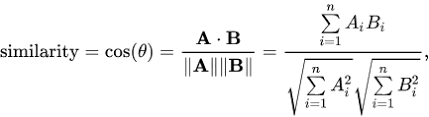

In [29]:
# Вычисляем матрицу косинусного сходства.
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [30]:
# Создайте обратное отображение индексов и названий фильмов
indices = pd.Series(items_df.index, index=items_df['item_id']).drop_duplicates()

In [31]:
train_part_3 = train_part.copy() # Делаем копию тренировочного датасета
train_part_3 = train_part_3.groupby("item_id").agg({"user_id":  "count"}).reset_index()
# Добавляем столбец Count_of_views, в который помещаем количество просмотров каждого фильма
train_part_3.rename(columns={"user_id": "Count_of_views"}, inplace=True)
np_train_part_3 = np.array(train_part_3['item_id'])
train_part_3['similar_films'] = None  # Создаем пустой столбец в DataFrame

In [32]:
def get_recommendations(item_id, cosine_sim=cosine_sim):
    # Получаем индекс фильма, соответствующего названию
    idx = indices[item_id]

    # Получаем попарные оценки сходства всех фильмов с данным фильмом.
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Сортируем фильмы
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Получаем топ-10 наиболее похожих фильмов
    sim_scores = sim_scores[1:11]

    movie_indices = [i[0] for i in sim_scores]

    # Возвращаем топ-10 наиболее похожих фильмов
    return items_df['item_id'].iloc[movie_indices]

In [33]:
# Создаем столбец similar_films, в итоге каждому фильму ставим топ-10 наиболее похожих фильмов
for i in tqdm(range(len(np_train_part_3))):
    train_part_3.at[i, 'similar_films'] = list(get_recommendations(np_train_part_3[i]))

100%|████████████████████████████████████| 12067/12067 [01:04<00:00, 186.24it/s]


Посмотрим как отработала наша функция, которая должна подбирать каждому фильм 10 наиболее похожих фильмов.
В качестве примера, рассмотрим фильм с индексом `item_id=0`

In [65]:
ids_1 = [0]
ids_2 = np.array(train_part_3)[0][2]
# items_df.loc[items_df['item_id'].isin(ids_1)]['title']
print(np.array(items_df.loc[items_df['item_id'].isin(ids_1)]['title'])[0])
# print()
print('На него большего всего похожи: \n',items_df.loc[items_df['item_id'].isin(ids_2)]['title'])

Смешарики: Азбука безопасности
На него большего всего похожи: 
 3258                          Смешарики: Азбука дружелюбия
4469              Робокар Поли. Правила дорожного движения
4925             Простые правила (сурдоперевод + субтитры)
5001        Лига Watchcar - Песни о безопасности на дороге
6311                           Смешарики: Обучающая азбука
6428                            Полезные советы Ангел Бэби
10868                По всем правилам вместе с Хрюшей и...
11129                                      Простые правила
11461    Лига WatchCar. Правила дорожного движения. Дет...
11678                         Смешарики. Новые приключения
Name: title, dtype: object


**Предварительный вывод**: 

Видим, что алгоритм более, чем успешно справился с задачей. Все 10 подобранных фильмов действительно похожи на заданный, по крайней мере судяпо названиям

Каждый пользователь посмотрел n количество фильмов (работаем с test_part), как писалось ранее каждому фильму ставится 10 похожих фильмов, соотвественно, если пользователь посмотрел 3 фильма, ему находят 30 похожих и далее выбирается 10 наиболее просмотренных исходя из таблицы train_part

In [35]:
test_part['recs'] = None  # Создаем пустой столбец для списков
np_test_part = np.array(test_part)
for i in tqdm(range(len(np_test_part))):
    find_sim = train_part_3.loc[train_part_3['item_id'].isin(np_test_part[i][1])]
    final = []
    for j in range(len(np_test_part[i][1])):
        final += np.array(find_sim)[j][2]
    
    sort_rating = train_part_3.loc[train_part_3['item_id'].isin(final)].sort_values(by=['Count_of_views'], ascending=False)
    test_part.at[i, 'recs'] = list(sort_rating['item_id'])[0:10]

100%|████████████████████████████████████| 18693/18693 [00:26<00:00, 701.64it/s]


In [36]:
evaluate_recommender(test_part, model_preds_col="recs")

{'ndcg': 0.11421112011897755, 'recall': 0.05144649614783853}

Несмотря на то, что система подбирала похожие фильмы, итоговые метрики оказались ниже, чем у метода TopPopular:(

С данным подходом я познакомился:
1. https://www.kaggle.com/code/ibtesama/getting-started-with-a-movie-recommendation-system
2. https://www.kaggle.com/code/rounakbanik/movie-recommender-systems/notebook

## Collaborative filtering (Модели матричной факторизации)

Главное отличие Collaborative filtering от Content-Based filtering заключается в том, что они не требуют метаданных элемента, как их контентные аналоги.

Одним из разветвлений Collaborative filtering является обширный класс моделей, основанных на **матричной факторизации**:

Алгоритмы **матричной факторизации** работают путем разложения матрицы взаимодействия пользователя и элемента на произведение двух прямоугольных матриц меньшей размерности.

In [5]:
# Класс, от которого будут наследоваться все модели:
class BaseRecommender(ABC):
    def __init__(self):
        self.trained = False

    @abstractmethod
    def fit(self, df: pd.DataFrame) -> None:
        # реализация может быть любой, никаких ограничений

        # не забудьте про
        self.trained = True

    @abstractmethod
    def predict(self, df: pd.DataFrame, topn: int = 10) -> List[np.ndarray]:
        # реализация может быть любой, НО
        # должен возвращать список массивов из item_id, которые есть в `item_df`, чтобы корректно работал подсчет метрик
        pass

Про данный метод читал документацию: https://web.stanford.edu/~rezab/nips2014workshop/submits/logmat.pdf

In [6]:
class LMR(BaseRecommender):
    def __init__(
        self, factors: int = 30, regularization: float = 0.6,learning_rate=1.0, iterations: int = 30, **kwargs
    ) -> None:
        super().__init__()
        self.model = LogisticMatrixFactorization(
            factors=factors, regularization=regularization, learning_rate=learning_rate, iterations=iterations, **kwargs
        )
        self.trained = False

    def fit(
        self, df: pd.DataFrame, item_col: str = "item_id", user_col: str = "user_id", value_col: str = None
    ) -> None:
        self.user_encoder = LabelEncoder()
        self.item_encoder = LabelEncoder()
        user_ids = self.user_encoder.fit_transform(df[user_col])
        item_ids = self.item_encoder.fit_transform(df[item_col])
        if value_col is None:
            counts = np.ones(len(df))
        else:
            counts = df[value_col].values

        matrix_shape = len(self.user_encoder.classes_), len(self.item_encoder.classes_)

        self.sparse = csr_matrix((counts, (user_ids, item_ids)), shape=matrix_shape)
        self.model.fit(self.sparse)

        self.trained = True

    def predict(self, df: pd.DataFrame, topn: int = 10) -> List[np.ndarray]:
        assert self.trained

        all_recs = []

        users = self.user_encoder.transform(df["user_id"])
        for user in tqdm(users, desc="predicting", leave=False):
            encoded_rec_items = self.model.recommend(user, user_items=self.sparse[user], N=topn)[0]
            all_recs.append(self.item_encoder.inverse_transform(encoded_rec_items))
        return all_recs

In [255]:
lmr_rec = LMR(random_state=0)
lmr_rec.fit(train_part)
test_part_lmr = test_part.copy() 
test_part_lmr["lmr_rec"] = lmr_rec.predict(test_part)
evaluate_recommender(test_part_lmr, model_preds_col="lmr_rec")

100%|███████████████████████████████████████████| 30/30 [00:13<00:00,  2.18it/s]


{'ndcg': 0.02247880300902104, 'recall': 0.008106251584124757}

Про данный метод читал документацию: https://arxiv.org/pdf/1205.2618.pdf

In [7]:
class BPRRecommender(BaseRecommender):
    # здесь вынесены только основные гиперпараметры модели, все вы можете посмотреть в документации
    def __init__(
        self, factors:int=10, learning_rate:float=0.001, iterations:int=1,**kwargs
    ) -> None:
        super().__init__()
        self.model = BayesianPersonalizedRanking(factors=factors,learning_rate=learning_rate, iterations=iterations,
             **kwargs
        )
        self.trained = False

    def fit(
        self, df: pd.DataFrame, item_col: str = "item_id", user_col: str = "user_id", value_col: str = None
    ) -> None:
        self.user_encoder = LabelEncoder()
        self.item_encoder = LabelEncoder()
        user_ids = self.user_encoder.fit_transform(df[user_col])
        item_ids = self.item_encoder.fit_transform(df[item_col])
        if value_col is None:
            counts = np.ones(len(df))
        else:
            counts = df[value_col].values

        matrix_shape = len(self.user_encoder.classes_), len(self.item_encoder.classes_)

        self.sparse = csr_matrix((counts, (user_ids, item_ids)), shape=matrix_shape)
        self.model.fit(self.sparse)

        self.trained = True

    def predict(self, df: pd.DataFrame, topn: int = 10) -> List[np.ndarray]:
        assert self.trained

        all_recs = []

        users = self.user_encoder.transform(df["user_id"])
        for user in tqdm(users, desc="predicting", leave=False):
            encoded_rec_items = self.model.recommend(user, user_items=self.sparse.getrow(user), N=topn)[0]
            all_recs.append(self.item_encoder.inverse_transform(encoded_rec_items))

        return all_recs

In [257]:
bpr_rec = BPRRecommender(random_state=0)
bpr_rec.fit(train_part)
test_part_brp=test_part.copy()
test_part_brp["bpr_rec"] = bpr_rec.predict(test_part)
evaluate_recommender(test_part_brp, model_preds_col="bpr_rec")

100%|████████████| 1/1 [00:00<00:00,  8.07it/s, train_auc=50.48%, skipped=2.27%]


{'ndcg': 0.06234111420108427, 'recall': 0.02518489415025145}

### Item-to-item модели (NearestNeighboursRecommender модели)

**Векторное представление для объекта** - весь столбец из матрицы взаимодействий (user_item) матрица

**Процесс построения рекомендаций** - поиск похожих объектов (по косинусной мере близости) для всех объектов, с которыми пользователь уже взаимодействовал и выдача топа из этого списка

**Пространство для тюнинга**:
1. `K` - количество соседей (Натуральные числа) 

In [8]:
class NearestNeighboursRecommender(BaseRecommender):
    def __init__(
        self,method, K: int = 10, **kwargs
    ) -> None:
        super().__init__()
        self.model = method(
            K=K, **kwargs
        )
        self.trained = False

    def fit(
        self, df: pd.DataFrame, item_col: str = "item_id", user_col: str = "user_id", value_col: str = None
    ) -> None:
        self.user_encoder = LabelEncoder()
        self.item_encoder = LabelEncoder()
        user_ids = self.user_encoder.fit_transform(df[user_col])
        item_ids = self.item_encoder.fit_transform(df[item_col])
        if value_col is None:
            counts = np.ones(len(df))
        else:
            counts = df[value_col].values

        matrix_shape = len(self.user_encoder.classes_), len(self.item_encoder.classes_)

        self.sparse = csr_matrix((counts, (user_ids, item_ids)), shape=matrix_shape)
        self.model.fit(self.sparse)

        self.trained = True

    def predict(self, df: pd.DataFrame, topn: int = 10) -> List[np.ndarray]:
        assert self.trained

        all_recs = []

        users = self.user_encoder.transform(df["user_id"])
        for user in users:
            encoded_rec_items = self.model.recommend(user, user_items=self.sparse.getrow(user), N=topn)[0]
            all_recs.append(self.item_encoder.inverse_transform(encoded_rec_items))

        return all_recs

In [259]:
nn_rec = NearestNeighboursRecommender(TFIDFRecommender)
nn_rec.fit(train_part)
test_part_nn = test_part.copy()
test_part_nn["nn_rec"] = nn_rec.predict(test_part_nn)
evaluate_recommender(test_part_nn, model_preds_col="nn_rec")

/home/andrey/.local/lib/python3.10/site-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.011445045471191406 seconds
  warnings.warn(
100%|█████████████████████████████████| 12067/12067 [00:00<00:00, 121207.91it/s]


{'ndcg': 0.09665179435339492, 'recall': 0.04330765498952161}

### AlternatingLeastSquares

**Векторное представление** - на основе разложения матрицы взамиодействий (с весами) в произведение двух матриц. Одна матрица размерности \[users x factors\] содержит векторные представления всех пользователей, другая матрица \[items x factors\] для объектов

**Процесс построения рекомендаций** - для конкретного пользователя ищутся такие объекты, что скалярное произведение их векторов максимально.

**Пространство для тюнинга**:

1.`factors` - размерность итоговых векторов (Натуральные числа)

2.`iterations` - кол-во итераций (Натуральные числа)

3.`regularization` - регуляризация векторов (степени 10-ки, от 0.001 до 1)

In [9]:
class ALS(BaseRecommender):
    def __init__(
        self, factors: int = 100, regularization: float = 0.01, alpha: float = 1.0, iterations: int = 5, **kwargs
    ) -> None:
        super().__init__()
        self.model = AlternatingLeastSquares(
            factors=factors, regularization=regularization, alpha=alpha, iterations=iterations, **kwargs
        )
        self.trained = False

    def fit(
        self, df: pd.DataFrame, item_col: str = "item_id", user_col: str = "user_id", value_col: str = None
    ) -> None:
        self.user_encoder = LabelEncoder()
        self.item_encoder = LabelEncoder()
        user_ids = self.user_encoder.fit_transform(df[user_col])
        item_ids = self.item_encoder.fit_transform(df[item_col])
        if value_col is None:
            counts = np.ones(len(df))
        else:
            counts = df[value_col].values

        matrix_shape = len(self.user_encoder.classes_), len(self.item_encoder.classes_)

        self.sparse = csr_matrix((counts, (user_ids, item_ids)), shape=matrix_shape)
        self.model.fit(self.sparse)

        self.trained = True

    def predict(self, df: pd.DataFrame, topn: int = 10) -> List[np.ndarray]:
        assert self.trained

        all_recs = []

        users = self.user_encoder.transform(df["user_id"])
        for user in tqdm(users, desc="predicting", leave=False):
            encoded_rec_items = self.model.recommend(user, user_items=self.sparse[user], N=topn)[0]
            all_recs.append(self.item_encoder.inverse_transform(encoded_rec_items))
        return all_recs

In [261]:
als_rec = ALS(iterations=1, factors=2,random_state=42)
als_rec.fit(train_part)
test_part_als = test_part.copy()
test_part_als["als_recs"] = als_rec.predict(test_part_als)
evaluate_recommender(test_part_als, model_preds_col="als_recs")

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s]


{'ndcg': 0.15702657768326359, 'recall': 0.06956445160783432}

Выше были рассмотрены модели и посчитаны для них метрики с учетом дефолтных настроек модели. С помощью подбора параметров, будем улучшать наши модели!

С данными подходами я познакомился:

1. https://www.kaggle.com/code/ibtesama/getting-started-with-a-movie-recommendation-system
2. https://www.kaggle.com/code/rounakbanik/movie-recommender-systems/notebook
3. https://web.stanford.edu/~rezab/nips2014workshop/submits/logmat.pdf
4. https://arxiv.org/pdf/1205.2618.pdf

## Тюнинг моделей

Ниже по очередно будут прогоняться параметры, последующие модели будут содержать предыдущего исследования

`LMR`(
    factors: int = 30,
    regularization: float = 0.6,
    iterations: int = 30,
    **kwargs,
) -> None

In [364]:
list_results = []

for iteration in range(1,11):
    lmr_rec = LMR(iterations=10*iteration,random_state=0)  # Создание экземпляра метода
    lmr_rec.fit(train_part)
    test_part_lmr = test_part.copy() 
    test_part_lmr["lmr_rec"] = lmr_rec.predict(test_part)
    list_results.append(evaluate_recommender(test_part_lmr, model_preds_col="lmr_rec"))  # Оценка результата

In [282]:
ndcg_massive = []
recall_massive = []
for i in range(10):
    ndcg_massive.append(list_results[i]['ndcg'])
    recall_massive.append(list_results[i]['recall'])

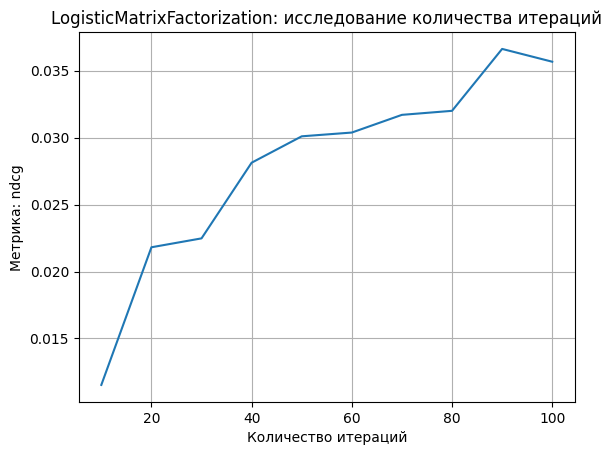

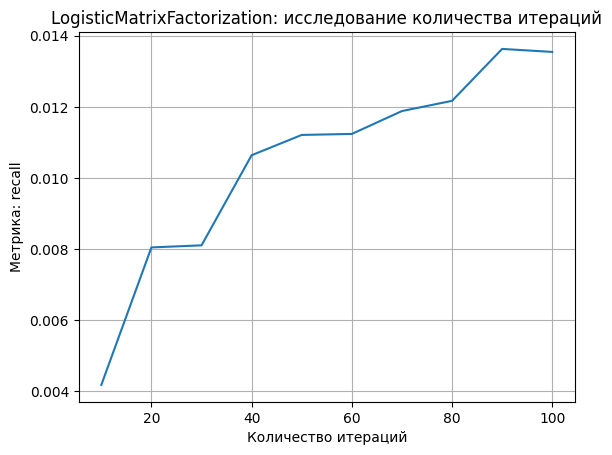

In [287]:
plt.figure()
plt.grid()
plt.plot(np.arange(10,110,10),ndcg_massive)
plt.xlabel('Количество итераций')
plt.ylabel('Метрика: ndcg')
plt.title('Logistic Matrix Factorization: зависимость ndcg от количества итераций')
plt.show()
plt.figure()
plt.grid()
plt.plot(np.arange(10,110,10),recall_massive)
plt.xlabel('Количество итераций')
plt.ylabel('Метрика: recall')
plt.title('LogisticMatrixFactorization: зависимость recall от количества итераций')
plt.show()

Наилучший результат получен при iteration = 100, будем учитывать это при подборе следующих параметров

In [363]:
list_results = []

for iteration in range(1,11):
    lmr_rec = LMR(iterations=100,factors=10*iteration,random_state=0)  # Создание экземпляра метода
    lmr_rec.fit(train_part)
    test_part_lmr = test_part.copy() 
    test_part_lmr["lmr_rec"] = lmr_rec.predict(test_part)
    list_results.append(evaluate_recommender(test_part_lmr, model_preds_col="lmr_rec"))  # Оценка результата

In [325]:
ndcg_massive = []
recall_massive = []
for i in range(10):
    ndcg_massive.append(list_results[i]['ndcg'])
    recall_massive.append(list_results[i]['recall'])

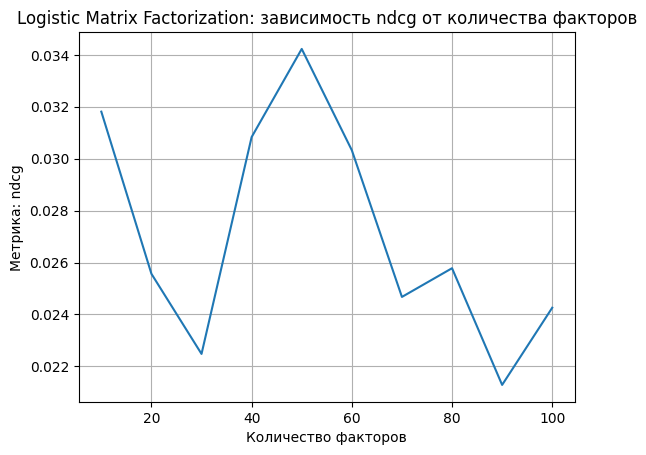

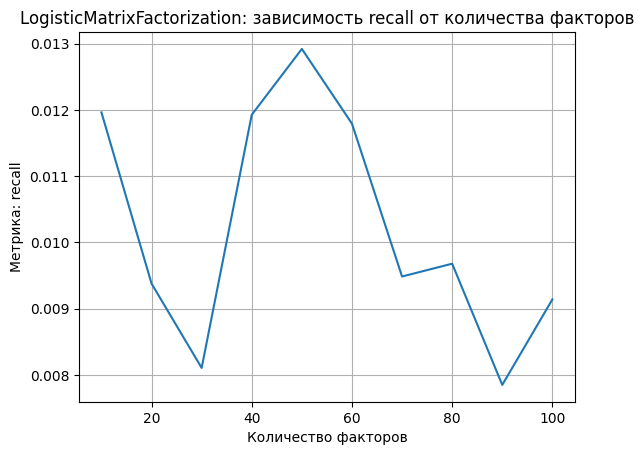

In [326]:
plt.figure()
plt.grid()
plt.plot(np.arange(10,110,10),ndcg_massive)
plt.xlabel('Количество факторов')
plt.ylabel('Метрика: ndcg')
plt.title('Logistic Matrix Factorization: зависимость ndcg от количества факторов')
plt.show()
plt.figure()
plt.grid()
plt.plot(np.arange(10,110,10),recall_massive)
plt.xlabel('Количество факторов')
plt.ylabel('Метрика: recall')
plt.title('LogisticMatrixFactorization: зависимость recall от количества факторов')
plt.show()

Наилучший результат получен при factors = 50

In [362]:
list_results = []

for iteration in range(1,11):
    lmr_rec = LMR(iterations=100,factors=50,regularization=0.1*iteration, random_state=0) # Создание экземпляра метода
    lmr_rec.fit(train_part)
    test_part_lmr = test_part.copy() 
    test_part_lmr["lmr_rec"] = lmr_rec.predict(test_part)
    list_results.append(evaluate_recommender(test_part_lmr, model_preds_col="lmr_rec"))  # Оценка результата

In [332]:
ndcg_massive = []
recall_massive = []
for i in range(10):
    ndcg_massive.append(list_results[i]['ndcg'])
    recall_massive.append(list_results[i]['recall'])

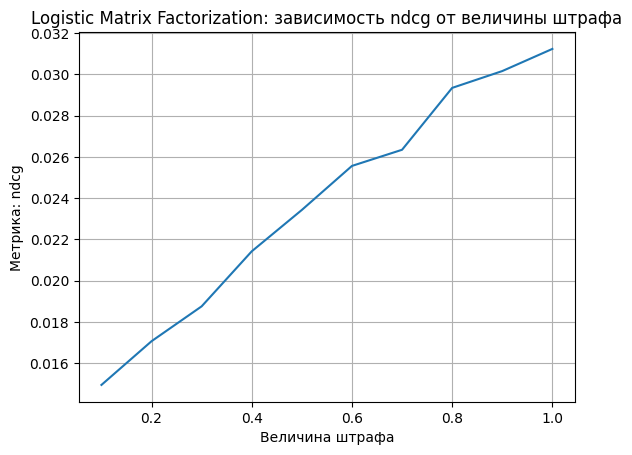

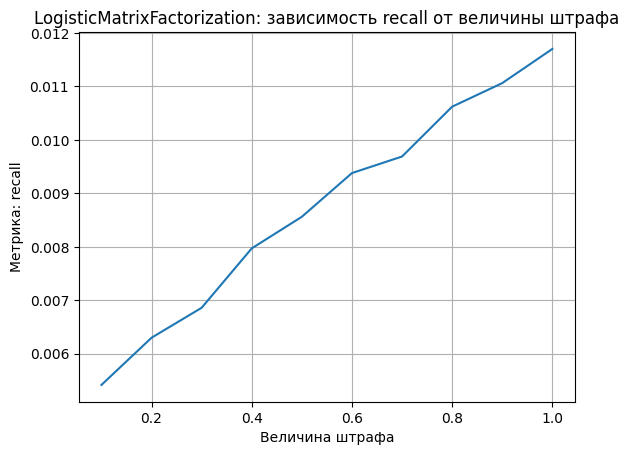

In [333]:
plt.figure()
plt.grid()
plt.plot(np.arange(0.1,1.1,0.1),ndcg_massive)
plt.xlabel('Величина штрафа')
plt.ylabel('Метрика: ndcg')
plt.title('Logistic Matrix Factorization: зависимость ndcg от величины штрафа')
plt.show()
plt.figure()
plt.grid()
plt.plot(np.arange(0.1,1.1,0.1),recall_massive)
plt.xlabel('Величина штрафа')
plt.ylabel('Метрика: recall')
plt.title('LogisticMatrixFactorization: зависимость recall от величины штрафа')
plt.show()

Наилучший результат получен при regularization = 1

`BayesianPersonalizedRanking`(
    factors=100,
    regularization=0.01,
    iterations=100
)

In [361]:
list_results = []
for iteration in range(1,11):
    bpr_rec = BPRRecommender(iterations=iteration*10,random_state=0) # Создание экземпляра метода
    bpr_rec.fit(train_part)
    test_part_brp=test_part.copy()
    test_part_brp["bpr_rec"] = bpr_rec.predict(test_part)
    list_results.append(evaluate_recommender(test_part_brp, model_preds_col="bpr_rec"))  # Оценка результата

In [311]:
ndcg_massive = []
recall_massive = []
for i in range(10):
    ndcg_massive.append(list_results[i]['ndcg'])
    recall_massive.append(list_results[i]['recall'])

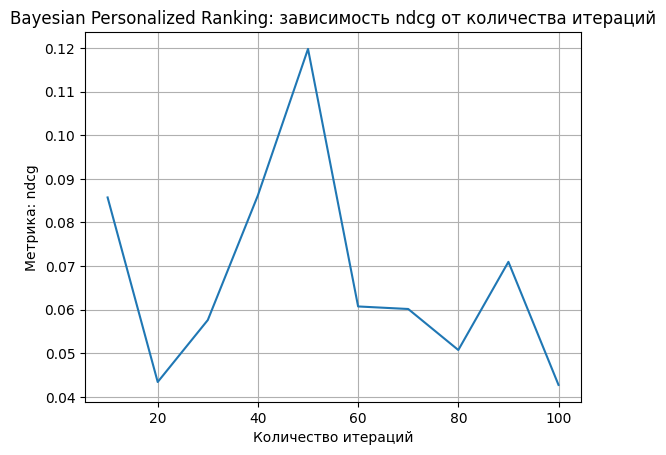

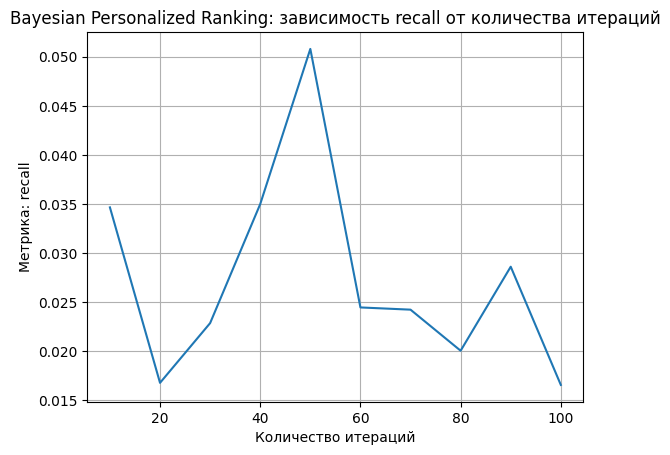

In [312]:
plt.figure()
plt.grid()
plt.plot(np.arange(10,110,10),ndcg_massive)
plt.xlabel('Количество итераций')
plt.ylabel('Метрика: ndcg')
plt.title('Bayesian Personalized Ranking: зависимость ndcg от количества итераций')
plt.show()
plt.figure()
plt.grid()
plt.plot(np.arange(10,110,10),recall_massive)
plt.xlabel('Количество итераций')
plt.ylabel('Метрика: recall')
plt.title('Bayesian Personalized Ranking: зависимость recall от количества итераций')
plt.show()

In [360]:
list_results = []
for iteration in range(1,11):
    bpr_rec = BPRRecommender(iterations=50, factors=50*iteration,random_state=42) # Создание экземпляра метода
    bpr_rec.fit(train_part)
    test_part_brp=test_part.copy()
    test_part_brp["bpr_rec"] = bpr_rec.predict(test_part)
    list_results.append(evaluate_recommender(test_part_brp, model_preds_col="bpr_rec"))  # Оценка результата

In [316]:
ndcg_massive = []
recall_massive = []
for i in range(10):
    ndcg_massive.append(list_results[i]['ndcg'])
    recall_massive.append(list_results[i]['recall'])

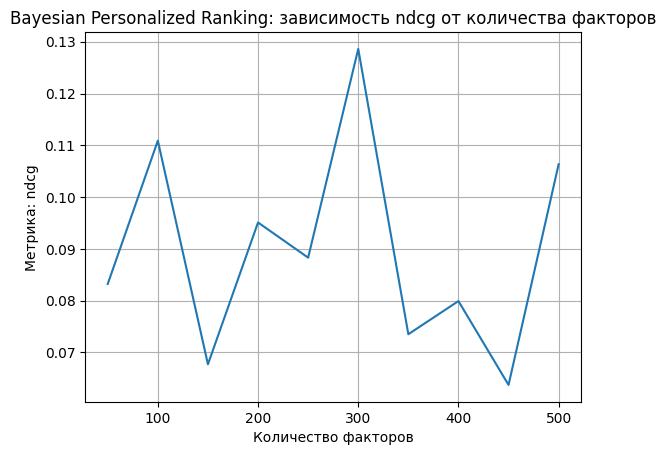

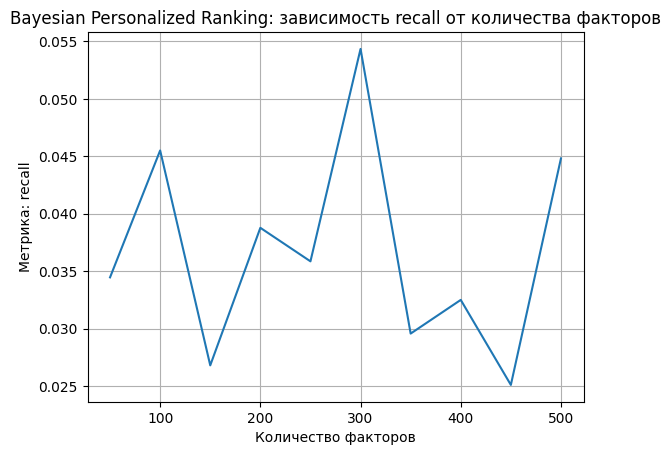

In [319]:
plt.figure()
plt.grid()
plt.plot(np.arange(50,550,50),ndcg_massive)
plt.xlabel('Количество факторов')
plt.ylabel('Метрика: ndcg')
plt.title('Bayesian Personalized Ranking: зависимость ndcg от количества факторов')
plt.show()
plt.figure()
plt.grid()
plt.plot(np.arange(50,550,50),recall_massive)
plt.xlabel('Количество факторов')
plt.ylabel('Метрика: recall')
plt.title('Bayesian Personalized Ranking: зависимость recall от количества факторов')
plt.show()

In [359]:
list_results = []
for iteration in range(1,11):
    bpr_rec = BPRRecommender(iterations=50, factors=300, regularization=0.01*iteration, random_state=42)  # Создание экземпляра метода
    bpr_rec.fit(train_part)
    test_part_brp=test_part.copy()
    test_part_brp["bpr_rec"] = bpr_rec.predict(test_part)
    list_results.append(evaluate_recommender(test_part_brp, model_preds_col="bpr_rec"))  # Оценка результата

In [321]:
ndcg_massive = []
recall_massive = []
for i in range(10):
    ndcg_massive.append(list_results[i]['ndcg'])
    recall_massive.append(list_results[i]['recall'])

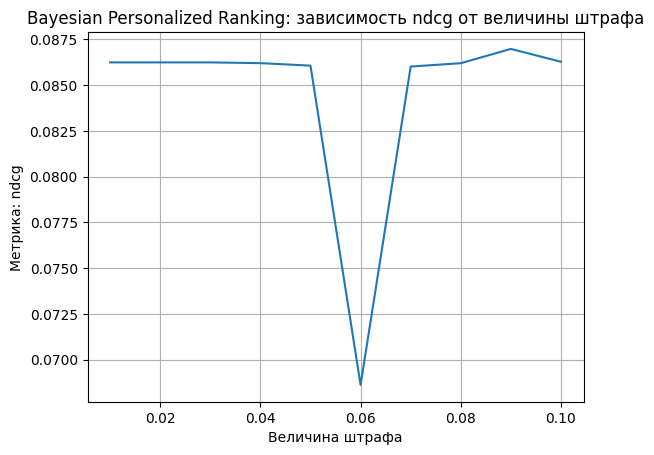

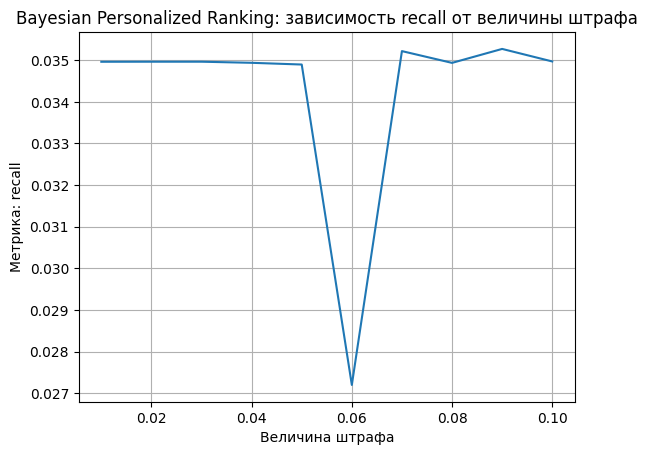

In [322]:
plt.figure()
plt.grid()
plt.plot(np.arange(0.01,0.11,0.01),ndcg_massive)
plt.xlabel('Величина штрафа')
plt.ylabel('Метрика: ndcg')
plt.title('Bayesian Personalized Ranking: зависимость ndcg от величины штрафа')
plt.show()
plt.figure()
plt.grid()
plt.plot(np.arange(0.01,0.11,0.01),recall_massive)
plt.xlabel('Величина штрафа')
plt.ylabel('Метрика: recall')
plt.title('Bayesian Personalized Ranking: зависимость recall от величины штрафа')
plt.show()

Bayesian Personalized Ranking основан на подходе условной вероятности по формуле Баейса. 

Я так понимаю, что поэтому каждый раз получаются разные резульаты, поэтому оказалось проблематично найти подходящие параметры.

Рассмотрим NearestNeighboursRecommender и 3 различных метода:

`TFIDFRecommender`(
    K=10
) -> None

`BM25Recommender`(
    K=10
) -> None

`CosineRecommender`(
    K=10
) -> None

In [358]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    methods = [TFIDFRecommender, BM25Recommender, CosineRecommender]  # Список методов
    ndcg = []
    recall = []
    for method in methods:
        ndcg_massive = []
        recall_massive = []
        
        for iteration in range(1, 11):
            knn_rec = NearestNeighboursRecommender(method, K=100 * iteration)  # Создание экземпляра метода
            knn_rec.fit(train_part)
            test_part_knn = test_part.copy()
            test_part_knn["knn_rec"] = knn_rec.predict(test_part)
            results = evaluate_recommender(test_part_knn, model_preds_col="knn_rec")  # Оценка результатов
            ndcg_massive.append(results['ndcg'])
            recall_massive.append(results['recall'])

        ndcg.append(ndcg_massive)
        recall.append(recall_massive)        

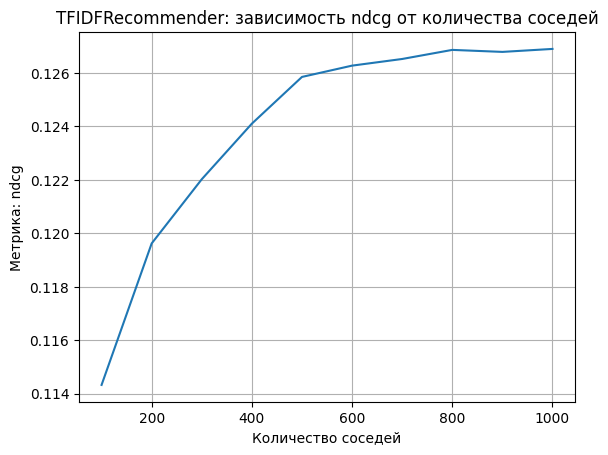

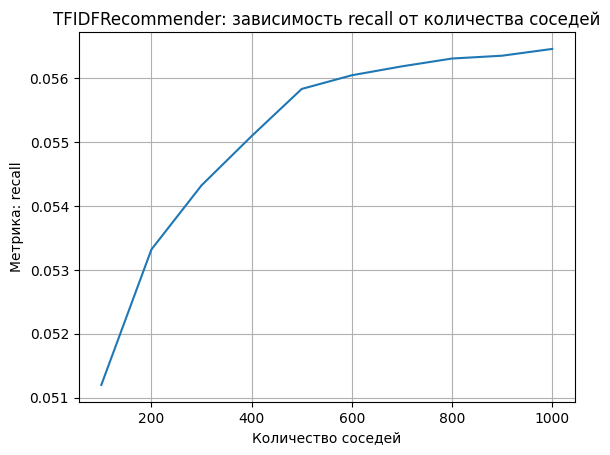

In [355]:
plt.figure()
plt.grid()
plt.plot(np.arange(100, 1100, 100), ndcg[0])
plt.xlabel('Количество соседей')
plt.ylabel('Метрика: ndcg')
plt.title('TFIDFRecommender: зависимость ndcg от количества соседей')
plt.show()
        
plt.figure()
plt.grid()
plt.plot(np.arange(100, 1100, 100), recall[1)
plt.xlabel('Количество соседей')
plt.ylabel('Метрика: recall')
plt.title('TFIDFRecommender: зависимость recall от количества соседей')
plt.show()

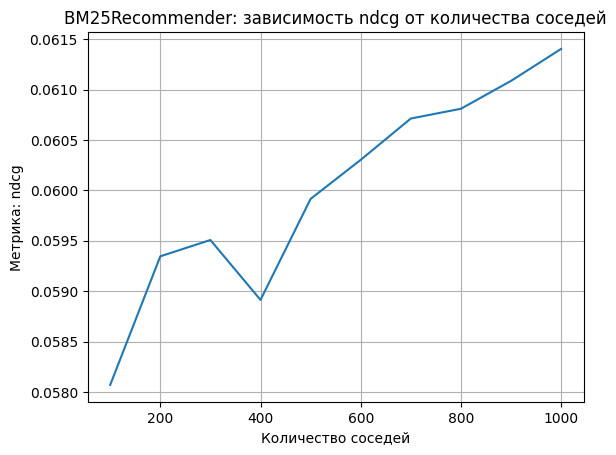

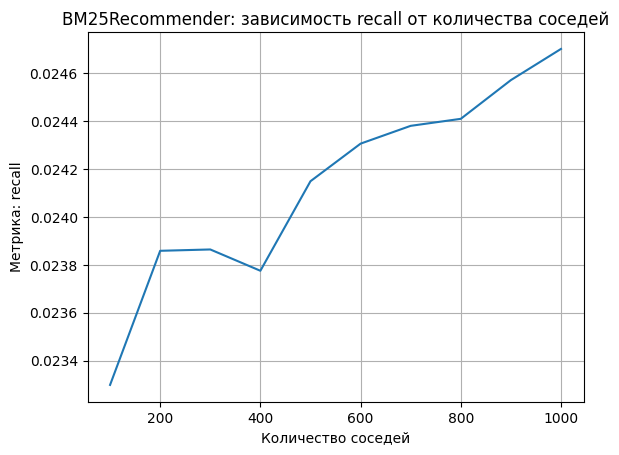

In [356]:
plt.figure()
plt.grid()
plt.plot(np.arange(100, 1100, 100), ndcg[1])
plt.xlabel('Количество соседей')
plt.ylabel('Метрика: ndcg')
plt.title('BM25Recommender: зависимость ndcg от количества соседей')
plt.show()
        
plt.figure()
plt.grid()
plt.plot(np.arange(100, 1100, 100), recall[1])
plt.xlabel('Количество соседей')
plt.ylabel('Метрика: recall')
plt.title('BM25Recommender: зависимость recall от количества соседей')
plt.show()

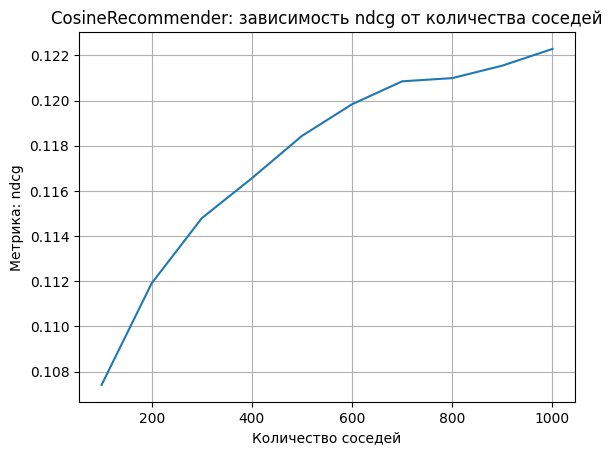

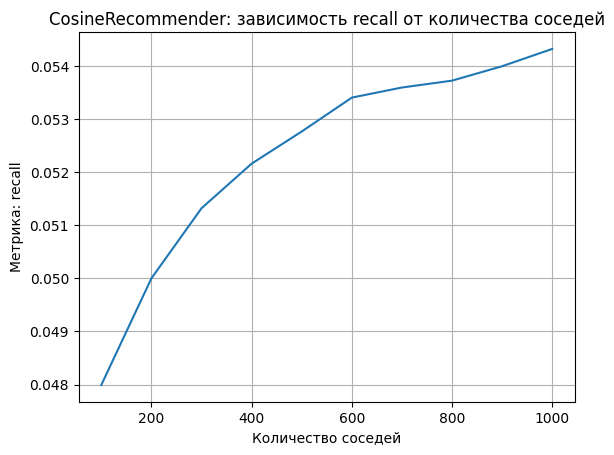

In [357]:
plt.figure()
plt.grid()
plt.plot(np.arange(100, 1100, 100), ndcg[2])
plt.xlabel('Количество соседей')
plt.ylabel('Метрика: ndcg')
plt.title('CosineRecommender: зависимость ndcg от количества соседей')
plt.show()
        
plt.figure()
plt.grid()
plt.plot(np.arange(100, 1100, 100), recall[2])
plt.xlabel('Количество соседей')
plt.ylabel('Метрика: recall')
plt.title('CosineRecommender: зависимость recall от количества соседей')
plt.show()

Во всех 3 случаях результат оказался лучшим при максимальном количестве соседей K=1000

Теперь вернемся к методу **ALS**, который был представлен в качестве примера.

Попробуем улучшить наши метрики!

`ALS`(
    factors: int = 100,
    regularization: float = 0.01,
    iterations: int = 5,
    **kwargs,
) -> None

In [372]:
ndcg_massive = []
recall_massive = []
for iteration in range(1,11):
    als_rec = ALS(iterations=10*iteration, factors=2,random_state=42)
    als_rec.fit(train_part)
    test_part_als=test_part.copy()
    test_part_als["als_rec"] = als_rec.predict(test_part)
    results = evaluate_recommender(test_part_als, model_preds_col="als_rec")
    ndcg_massive.append(results['ndcg'])
    recall_massive.append(results['recall'])

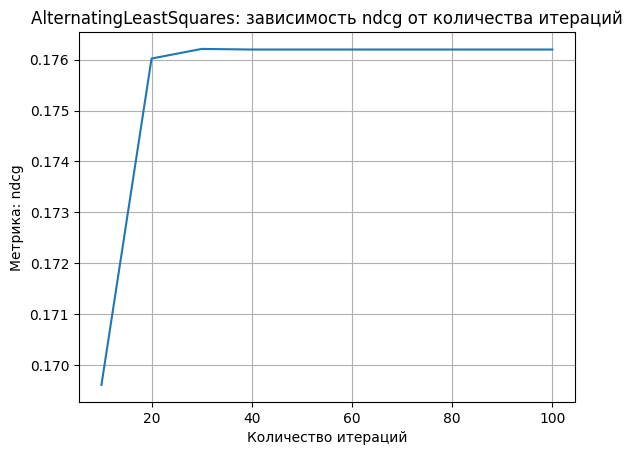

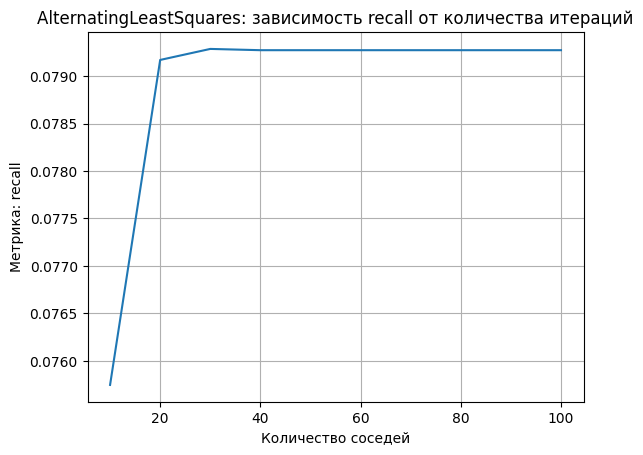

In [368]:
plt.figure()
plt.grid()
plt.plot(np.arange(10, 110, 10), ndcg_massive)
plt.xlabel('Количество итераций')
plt.ylabel('Метрика: ndcg')
plt.title('AlternatingLeastSquares: зависимость ndcg от количества итераций')
plt.show()
        
plt.figure()
plt.grid()
plt.plot(np.arange(10, 110, 10), recall_massive)
plt.xlabel('Количество соседей')
plt.ylabel('Метрика: recall')
plt.title('AlternatingLeastSquares: зависимость recall от количества итераций')
plt.show()

Так как после iterations > 20, особо результат не увеличивается, но зато сильно увеличивается время работы, остановимся на iterations = 20

In [371]:
ndcg_massive = []
recall_massive = []
for iteration in range(1,11):
    als_rec = ALS(iterations=20, factors=1*iteration,random_state=42)
    als_rec.fit(train_part)
    test_part_als=test_part.copy()
    test_part_als["als_rec"] = als_rec.predict(test_part)
    results = evaluate_recommender(test_part_als, model_preds_col="als_rec")
    ndcg_massive.append(results['ndcg'])
    recall_massive.append(results['recall'])

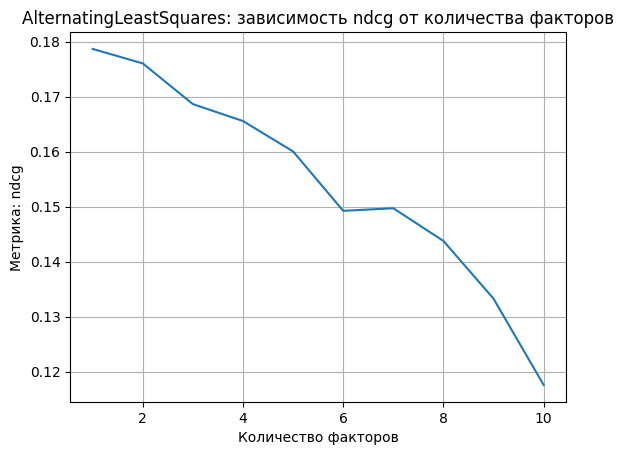

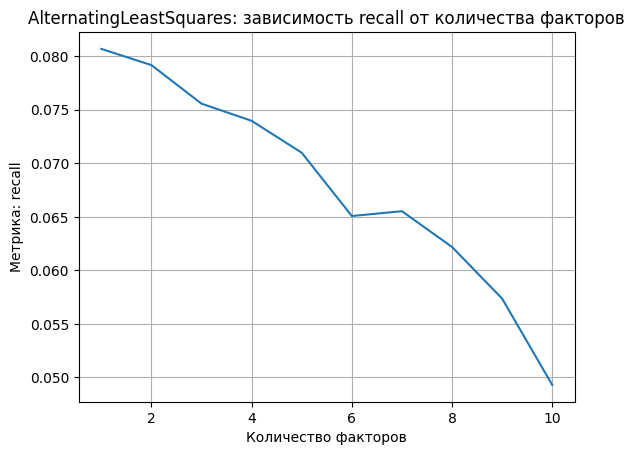

In [370]:
plt.figure()
plt.grid()
plt.plot(np.arange(1, 11), ndcg_massive)
plt.xlabel('Количество факторов')
plt.ylabel('Метрика: ndcg')
plt.title('AlternatingLeastSquares: зависимость ndcg от количества факторов')
plt.show()
        
plt.figure()
plt.grid()
plt.plot(np.arange(1, 11), recall_massive)
plt.xlabel('Количество факторов')
plt.ylabel('Метрика: recall')
plt.title('AlternatingLeastSquares: зависимость recall от количества факторов')
# plt.show()

С количеством факторов, результат модели ухудился, значит, берем factors = 1

In [382]:
ndcg_massive = []
recall_massive = []
for iteration in range(1,11):
    als_rec = ALS(iterations=20, factors=1,regularization=0.01*iteration, random_state=42)
    als_rec.fit(train_part)
    test_part_als=test_part.copy()
    test_part_als["als_rec"] = als_rec.predict(test_part)
    results = evaluate_recommender(test_part_als, model_preds_col="als_rec")
    ndcg_massive.append(results['ndcg'])
    recall_massive.append(results['recall'])

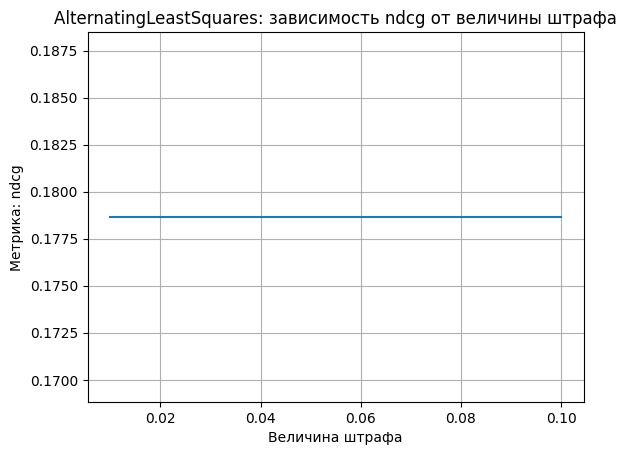

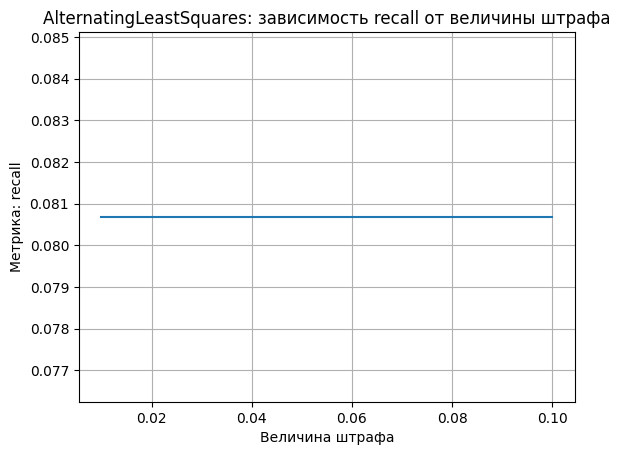

In [376]:
plt.figure()
plt.grid()
plt.plot(np.arange(0.01,0.11,0.01), ndcg_massive)
plt.xlabel('Величина штрафа')
plt.ylabel('Метрика: ndcg')
plt.title('AlternatingLeastSquares: зависимость ndcg от величины штрафа')
plt.show()
        
plt.figure()
plt.grid()
plt.plot(np.arange(0.01,0.11,0.01), recall_massive)
plt.xlabel('Величина штрафа')
plt.ylabel('Метрика: recall')
plt.title('AlternatingLeastSquares: зависимость recall от величины штрафа')
plt.show()

От результата штрафа результата оказался не зависим

## Результаты

Были расмотрены различные модели, таблица ниже:

In [10]:
results = {}

als_rec = ALS(iterations=20, factors=1,regularization=0.01, random_state=42)
als_rec.fit(train_part)
test_part_als=test_part.copy()
test_part_als["als_rec"] = als_rec.predict(test_part)
results['als_rec'] = evaluate_recommender(test_part_als, model_preds_col="als_rec")

100%|███████████████████████████████████████████| 20/20 [00:10<00:00,  1.96it/s]


In [11]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    methods = [TFIDFRecommender, BM25Recommender, CosineRecommender]  # Список методов

    for method in methods:
        knn_rec = NearestNeighboursRecommender(method, K=1000)  # Создание экземпляра метода
        knn_rec.fit(train_part)
        test_part_knn = test_part.copy()
        test_part_knn["knn_rec"] = knn_rec.predict(test_part)
        results[f'{method.__name__}'] = evaluate_recommender(test_part_knn, model_preds_col="knn_rec")  # Оценка результатов      

100%|██████████████████████████████████| 12067/12067 [00:00<00:00, 74049.80it/s]


In [12]:
lmr_rec = LMR(iterations=100,factors=50,regularization=1,random_state=42)  # Создание экземпляра метода
lmr_rec.fit(train_part)
test_part_lmr = test_part.copy() 
test_part_lmr["lmr_rec"] = lmr_rec.predict(test_part)
results['lmr_rec'] = evaluate_recommender(test_part_lmr, model_preds_col="lmr_rec")  # Оценка результата

100%|█████████████████████████████████████████| 100/100 [01:26<00:00,  1.15it/s]


In [13]:
bpr_rec = BPRRecommender(iterations=50, factors=300, regularization=0.01, random_state=0) # Создание экземпляра метода
bpr_rec.fit(train_part)
test_part_brp = test_part.copy()
test_part_brp["bpr_rec"] = bpr_rec.predict(test_part)
results['bpr_rec'] = evaluate_recommender(test_part_brp, model_preds_col="bpr_rec")  # Оценка результата

100%|██████████| 50/50 [00:24<00:00,  2.03it/s, train_auc=50.51%, skipped=2.26%]


In [14]:
results

{'als_rec': {'ndcg': 0.1786600972160223, 'recall': 0.08068228550320375},
 'TFIDFRecommender': {'ndcg': 0.1269019059036096,
  'recall': 0.05645687038238002},
 'BM25Recommender': {'ndcg': 0.0614029219186784,
  'recall': 0.02470085253462257},
 'CosineRecommender': {'ndcg': 0.12228548144581378,
  'recall': 0.05431774246060392},
 'lmr_rec': {'ndcg': 0.045454338892939726, 'recall': 0.017368035661936333},
 'bpr_rec': {'ndcg': 0.0627037507991221, 'recall': 0.02502695301007495}}

In [15]:
data_results_1 = {'methods':['LogisticMatrixFactorization', 'BayesianPersonalizedRanking', 'TFIDFRecommender', 'AlternatingLeastSquares'],
               'ndcg(before)': [0.02247880300902104, 0.06234111420108427,0.09665179435339492,0.15702657768326359],
               'ndcg(after)':[0.045454338892939726,0.0627037507991221,0.1269019059036096,0.1786600972160223],
               'recall(before)': [0.008106251584124757, 0.02518489415025145, 0.04330765498952161, 0.06956445160783432], 
               'recall(after)':[0.017368035661936333,0.02502695301007495, 0.05645687038238002, 0.08068228550320375]}
df_results_1 = pd.DataFrame(data=data_results_1)
df_results_1

,methods,ndcg(before),ndcg(after),recall(before),recall(after)
0,LogisticMatrixFactorization,0.022479,0.045454,0.008106,0.017368
1,BayesianPersonalizedRanking,0.062341,0.062704,0.025185,0.025027
2,TFIDFRecommender,0.096652,0.126902,0.043308,0.056457
3,AlternatingLeastSquares,0.157027,0.178660,0.069564,0.080682


Как видно из таблицы выше, настройка параметров очень важна, так как с помощью нее, можно улучшить итоговой скор.

Общая таблица со всеми результатами выглядит следующим образом.

In [16]:
data_results_2 = {'methods':['ContentBasedRecommender','LogisticMatrixFactorization', 'BayesianPersonalizedRanking', 'TFIDFRecommender', 'BM25Recommender', 'CosineRecommender', 'AlternatingLeastSquares'],
               'ndcg':[0.11421112011897755, 0.045454338892939726,0.0627037507991221,0.1269019059036096,0.0614029219186784,0.12228548144581378,0.1786600972160223],
               'recall':[0.05144649614783853, 0.017368035661936333,0.02502695301007495, 0.02470085253462257, 0.05645687038238002,0.05431774246060392, 0.08068228550320375]}
df_results_2 = pd.DataFrame(data=data_results_2)
df_results_2

,methods,ndcg,recall
0,ContentBasedRecommender,0.114211,0.051446
1,LogisticMatrixFactorization,0.045454,0.017368
2,BayesianPersonalizedRanking,0.062704,0.025027
3,TFIDFRecommender,0.126902,0.024701
4,BM25Recommender,0.061403,0.056457
5,CosineRecommender,0.122285,0.054318
6,AlternatingLeastSquares,0.178660,0.080682


## Визаулизация результатов

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    knn_rec = NearestNeighboursRecommender(TFIDFRecommender, K=1000)
    knn_rec.fit(train_part)
    test_part_knn = test_part.copy()
    test_part_knn["knn_rec"] = knn_rec.predict(test_part)

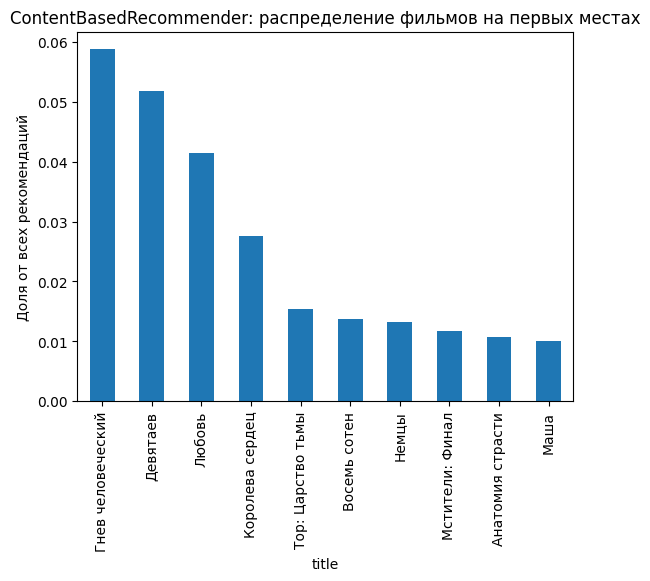

In [58]:
items_1 = pd.DataFrame([x[0] for x in test_part["recs"].values], columns=["item_id"])
items_1 = (
    items_1.merge(items_df[["item_id", "title"]], on="item_id").groupby("title").size().sort_values(ascending=False)
)
items_1 /= items_1.sum()
items_1.head(10).plot(kind="bar")
plt.ylabel("Доля от всех рекомендаций")
plt.title("ContentBasedRecommender: распределение фильмов на первых местах")
plt.show()

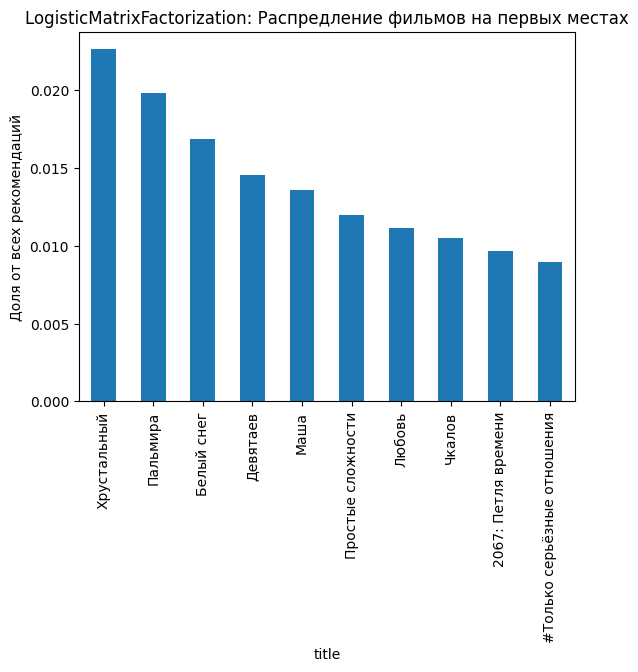

In [57]:
items_2 = pd.DataFrame([x[0] for x in test_part_lmr["lmr_rec"].values], columns=["item_id"])
items_2 = (
    items_2.merge(items_df[["item_id", "title"]], on="item_id").groupby("title").size().sort_values(ascending=False)
)
items_2 /= items_2.sum()
items_2.head(10).plot(kind="bar")
plt.ylabel("Доля от всех рекомендаций")
plt.title("LogisticMatrixFactorization: распределение фильмов на первых местах")
plt.show()

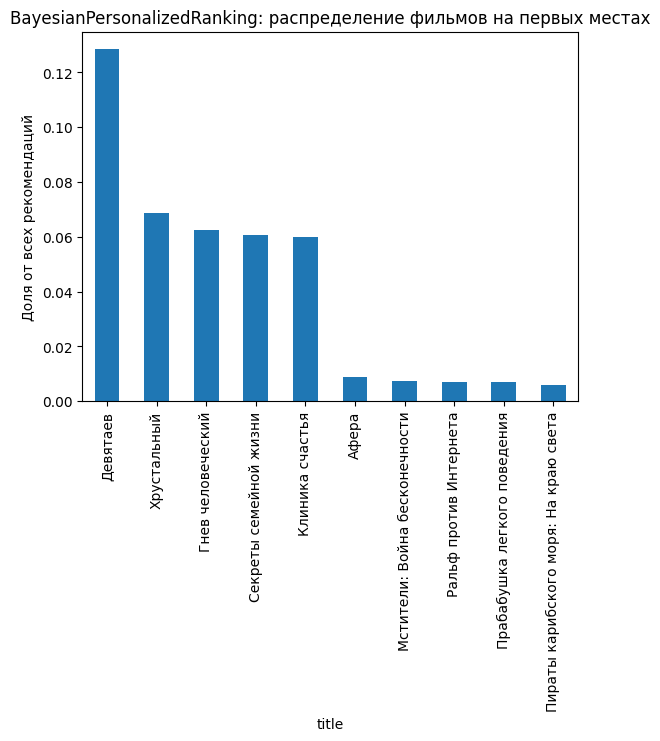

In [62]:
items_3 = pd.DataFrame([x[0] for x in test_part_knn["knn_rec"].values], columns=["item_id"])
items_3 = (
    items_3.merge(items_df[["item_id", "title"]], on="item_id").groupby("title").size().sort_values(ascending=False)
)
items_3 /= items_3.sum()
items_3.head(10).plot(kind="bar")
plt.ylabel("Доля от всех рекомендаций")
plt.title("BayesianPersonalizedRanking: распределение фильмов на первых местах")
plt.show()

In [40]:
def get_similar_films(method_rec, title, N=10):
    item_id = items_df[items_df["title"] == title]['item_id'].values[0]

    similar_encoded_ids = method_rec.model.similar_items(
        method_rec.item_encoder.transform([item_id]), N=N, filter_items=method_rec.item_encoder.transform([item_id])
    )[0][0]
    similar_ids = method_rec.item_encoder.inverse_transform(similar_encoded_ids)
    return items_df[items_df["item_id"].isin(similar_ids)]["title"]

In [50]:
ids_1 = [0]
ids_2 = np.array(train_part_3)[0][2]
print(np.array(items_df.loc[items_df['item_id'].isin(ids_1)]['title'])[0])
print("Больше всего похожи следующие 10 фильмов:")
print(items_df.loc[items_df['item_id'].isin(ids_2)]['title'])

Смешарики: Азбука безопасности
Больше всего похожи следующие 10 фильмов:
3258                          Смешарики: Азбука дружелюбия
4469              Робокар Поли. Правила дорожного движения
4925             Простые правила (сурдоперевод + субтитры)
5001        Лига Watchcar - Песни о безопасности на дороге
6311                           Смешарики: Обучающая азбука
6428                            Полезные советы Ангел Бэби
10868                По всем правилам вместе с Хрюшей и...
11129                                      Простые правила
11461    Лига WatchCar. Правила дорожного движения. Дет...
11678                         Смешарики. Новые приключения
Name: title, dtype: object


ALS recommender

In [51]:
print("Смешарики: Азбука безопасности")
print("Больше всего похожи следующие 10 фильмов:")
get_similar_films(als_rec, "Смешарики: Азбука безопасности")

Смешарики: Азбука безопасности
Больше всего похожи следующие 10 фильмов:


870                            Орбита 9
3720         Пинкфонг. Песни про космос
3782                 Капкан для Золушки
4526                  Второй шанс Кэрол
4578                           Единичка
4847             Красота по-американски
5705                    Седьмой спутник
8441     Новые приключения Дони и Микки
8463                     В ритме сердца
11734                   Общее достояние
Name: title, dtype: object

LMF recommender

In [52]:
print("Смешарики: Азбука безопасности")
print("Больше всего похожи следующие 10 фильмов:")
get_similar_films(lmr_rec, "Смешарики: Азбука безопасности")

Смешарики: Азбука безопасности
Больше всего похожи следующие 10 фильмов:


1144                             Помнить все
1382        Принцесса Лебедь: Царство музыки
1671     План побега 3 (с тифлокомментарием)
3258            Смешарики: Азбука дружелюбия
3330                          Защитники снов
3392                   Катино счастье тест 2
4405                          Истории свинок
4972                    В гости к Робинсонам
6558        Учим географию вместе с Ам Нямом
10242                   Бодо Бородо: Песенки
Name: title, dtype: object

In [54]:
print("Смешарики: Азбука безопасности")
print("Больше всего похожи следующие 10 фильмов:")
get_similar_films(knn_rec, "Смешарики: Азбука безопасности")

Смешарики: Азбука безопасности
Больше всего похожи следующие 10 фильмов:


986      Кэти Перри: Частичка меня (субтитры)
1685                      Любопытный Джордж 3
3020             Друзья. Приключения медвежат
4092                        Овощная вечеринка
5818                     Профессор Почемушкин
6485                             Спасти Санту
8013            Отличный гамбургер (субтитры)
8238       Список «Гори всё огнём» (субтитры)
9238               Последний замок (субтитры)
10242                    Бодо Бородо: Песенки
Name: title, dtype: object

Как уже писалось ранее, наиболее похожие фильмы дает метод Content-Based filtering. В других случаях на наш мультик подбираются тоже мультики, но менее похожие на заданный.

## Выводы

1. Была рассмотрена одна модель на основе Content-Based filtering (ndcg = 0.114211; recall = 0.051446)
2. Была рассмотрены четыре модели на основе collaborative filtering, лучший результат затюненный ALS (ndcg = 0.178660; recall = 0.080682)
3. С учетом построенных моделей и на их основе визуализации, хочется сделать вывод, что для построения лучшей модели недостаточно одного способа. Необходимо строить Hybrid filtering, который бы включал подбор наиболее популярных фильмов после чего путем collaborative filtering происходила ранжировка.

P.s. К сожалению, у меня не получилось реализовать данный Hybrid filtering, в одном случае просто непонятные ошибки, в другом случае слишком низкие метрики. Однако я познакомился с литературой и документацией LightFM (один из способов построения Hybrid filtering) и знаю с чего начинать в решение следующего кейса.

1. https://github.com/lyst/lightfm/
2. https://making.lyst.com/lightfm/docs/home.html
3. https://www.kaggle.com/code/sharthz23/implicit-lightfm/notebook
4. https://www.kaggle.com/code/niyamatalmass/lightfm-hybrid-recommendation-system


P.P.s. *Почему я выбрал данный кейс?* Во-первых, хотелось попробовать совершенно что-то новое, потому что ранее не было опыта решения задач RecSys, другие два кейса показались более знакомыми. Во-вторых, с точки зрения прикладного значения, показалось наиболее интересно. 

P.P.P.s. Это было очень интересное погружение в мир RecSys, ниже я оставлю все источники, с которыми я успел познакомиться за недельный промежуток. Спасибо за интересный кейс!

## Все источники

Тут представлены основные ссылки, которые легли в мою работу:)

1. Самая содержательная статья о всех рекомендательных фильтрах: https://habr.com/ru/articles/486802/
2. Введение в рекомендательные системы: https://habr.com/ru/articles/476222/
3. Про collaborative filtering: https://ru.wikibrief.org/wiki/Collaborative_filtering
4. Про матричную факторизацию: https://ru.wikibrief.org/wiki/Matrix_factorization_(recommender_systems)
5. Про KNN: https://www.benfrederickson.com/distance-metrics/
6. Про LMF: https://web.stanford.edu/~rezab/nips2014workshop/submits/logmat.pdf
7. Про BPR: https://arxiv.org/pdf/1205.2618.pdf
8. Про использование пакетов implicit, LightFM: https://www.kaggle.com/code/sharthz23/implicit-lightfm/notebook
9. Про использование пакетов LightFM: https://www.kaggle.com/code/niyamatalmass/lightfm-hybrid-recommendation-system